<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Segmenting-and-Clustering-Neighborhood-in-Toronto" data-toc-modified-id="Segmenting-and-Clustering-Neighborhood-in-Toronto-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Segmenting and Clustering Neighborhood in Toronto</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Scrape-data-from-Wekipedia" data-toc-modified-id="Scrape-data-from-Wekipedia-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Scrape data from Wekipedia</a></span></li><li><span><a href="#Add-more-geospatial-information" data-toc-modified-id="Add-more-geospatial-information-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Add more geospatial information</a></span></li></ul></li><li><span><a href="#Neighborhood-Segementation" data-toc-modified-id="Neighborhood-Segementation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Neighborhood Segementation</a></span><ul class="toc-item"><li><span><a href="#Get-Venue-information-using-Foursquare-API" data-toc-modified-id="Get-Venue-information-using-Foursquare-API-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Get Venue information using Foursquare API</a></span></li><li><span><a href="#Generate-features-for-clustering" data-toc-modified-id="Generate-features-for-clustering-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Generate features for clustering</a></span></li><li><span><a href="#Apply-Elbow-method-to-determine-the-number-of-clusters" data-toc-modified-id="Apply-Elbow-method-to-determine-the-number-of-clusters-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Apply Elbow method to determine the number of clusters</a></span></li><li><span><a href="#insights-from-result" data-toc-modified-id="insights-from-result-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>insights from result</a></span></li><li><span><a href="#Visualization-using-Folium" data-toc-modified-id="Visualization-using-Folium-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Visualization using Folium</a></span></li></ul></li></ul></li></ul></div>

# Segmenting and Clustering Neighborhood in Toronto 

## Data Preparation 

In [186]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans



### Scrape data from Wekipedia

In [187]:
# Get requests 
requests = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
neighborhood = BeautifulSoup(requests.text) 
tables = neighborhood.find_all("table")

# Convert to pandas table 
table = []
for row in tables[0].find_all("tr"): 
    row_data = [] 
    
    for cell in row.find_all("td"): 
        row_data.append(cell.text)
    
    if not row_data == []: 
        table.append(row_data)

data = pd.DataFrame(table, columns = ["PostalCode", "Borough", "Neighborhood"])

# Remove \n 
data = data.replace("\n","", regex=True)

# Remove observations where Borough = Not assigned
data = data[data.Borough != "Not assigned"]
data

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [188]:
print(f"- There are {data.shape[0]} rows in the dataframe")

- There are 103 rows in the dataframe


### Add more geospatial information

In [189]:
# Add coordinates 
coordinates = pd.read_csv("http://cocl.us/Geospatial_data")
data = pd.merge(data, coordinates, left_on="PostalCode", right_on="Postal Code", how="left").drop(columns=["Postal Code"])

In [190]:
data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [191]:
print('- The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(data['Borough'].unique()),
        data.shape[0]
    )
)

- The dataframe has 10 boroughs and 103 neighborhoods.


## Neighborhood Segementation
Here I'm going to segment all neighborhoods in Toronto. The frequency of venues in each neighborhood will be used as key features to cluster similar neighborhoods. Elbow method is used to deicde the number of clusters and Folium is used map each neighborhood point on the map.

In [192]:
# Get the latitude and longitude of Toronto 
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="trt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Get Venue information using Foursquare API 

In [193]:
# get top 100 venues that are in each neighborhoods within a radius of 500 meters
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
CLIENT_ID = "AA405KPT040BGEPDFRROHTRLTYDACBRK1DWXYQ0X5E4TVWLJ"
CLIENT_SECRET = "QO3DV3PDE0MUIFCODTOMPNUFHPDC4IXXYC0JXXDXCP2BGWSR"
VERSION = '20180605'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [194]:
toronto_venues = getNearbyVenues(names=data['Neighborhood'],
                                   latitudes=data['Latitude'],
                                   longitudes=data['Longitude']
                                  )

Parkwoods


AttributeError: 'Response' object has no attribute 'get'

In [ ]:
toronto_venues.rename(columns={"Neighborhood":"Neighborhoods"}, inplace=True)
toronto_venues

### Generate features for clustering 

In [ ]:
# use one-hot encoding to Venue Category 
toronto_venues.rename(columns={"Neighborhood":"Neighborhoods"}, inplace=True)
ohe = OneHotEncoder(sparse=False, dtype=int)

toronto_oht = pd.concat((toronto_venues, pd.DataFrame(ohe.fit_transform(toronto_venues[["Venue Category"]]),
                           columns=ohe.categories_[0])),
          axis=1)
toronto_oht

In [195]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_oht.groupby('Neighborhoods').mean().reset_index()
toronto_grouped 

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,43.794200,-79.262029,43.792613,-79.261140,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",43.602414,-79.543484,43.601800,-79.544687,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,43.755657,-79.440379,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,43.786947,-79.385975,43.787903,-79.380860,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",43.733282,-79.419750,43.733831,-79.419433,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale East",43.770120,-79.408493,43.768706,-79.412752,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0
92,"Willowdale, Willowdale West",43.782736,-79.442259,43.783574,-79.445919,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
93,Woburn,43.770992,-79.216917,43.771113,-79.220309,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,43.695344,-79.318389,43.696405,-79.315029,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[5:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [197]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Clothing Store,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Coffee Shop,Athletics & Sports,Sandwich Place,Pub,Pool,Distribution Center,Dim Sum Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Shopping Mall,Sandwich Place,Deli / Bodega,Supermarket,Mobile Phone Shop,Sushi Restaurant,Ice Cream Shop,Fried Chicken Joint
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Restaurant,Thai Restaurant,Greek Restaurant,Pizza Place,Comfort Food Restaurant,Juice Bar,Butcher


### Apply Elbow method to determine the number of clusters

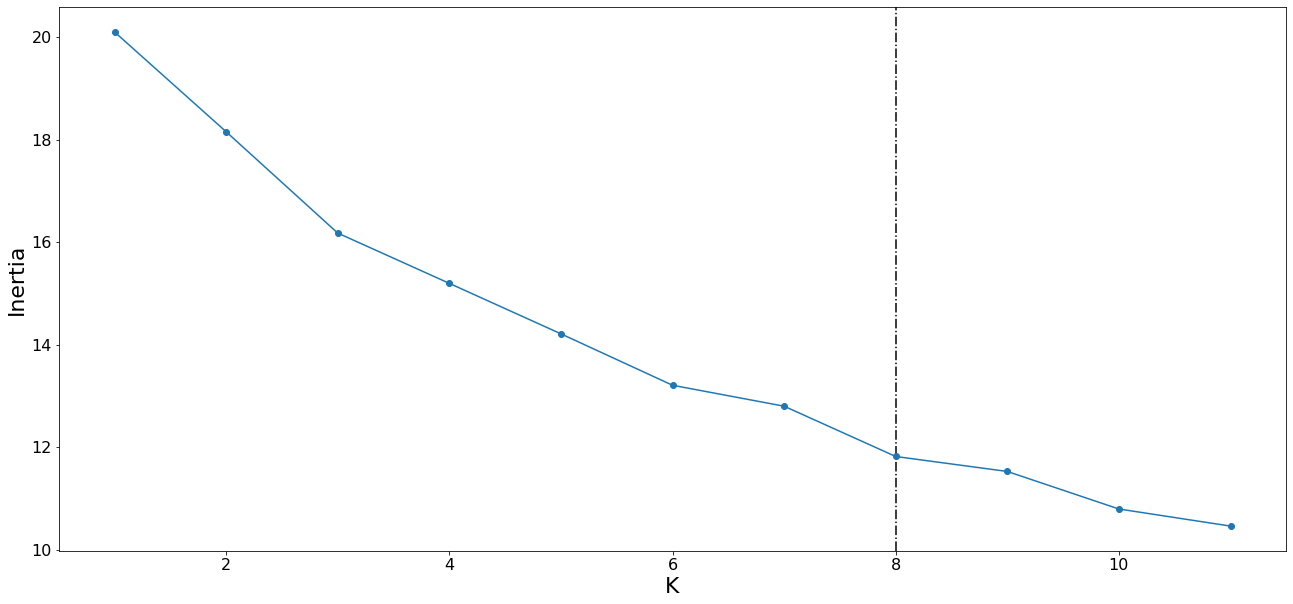

In [198]:
# Cluster neighborhood 
toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighborhoods', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue Latitude', 'Venue Longitude'])


# Use elbow methods to decide k
kmeans = list()
for k in range(1,12):
    kmeans.append(KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering))
    
    
def plot_elbow(w, h, kmeans):
    plt.figure(figsize = (w,h))
    plt.axvline(x=8, linestyle='-.', c="black")
    plt.plot(range(1,12),[k.inertia_ for k in kmeans], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)
    
plot_elbow(22,10, kmeans)

- Given the Elbow plot, I'll use cluster neighborhoods in 8 clusters.

In [199]:
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [200]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Clothing Store,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,0,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Coffee Shop,Athletics & Sports,Sandwich Place,Pub,Pool,Distribution Center,Dim Sum Restaurant
2,1,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Shopping Mall,Sandwich Place,Deli / Bodega,Supermarket,Mobile Phone Shop,Sushi Restaurant,Ice Cream Shop,Fried Chicken Joint
3,1,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio
4,1,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Restaurant,Thai Restaurant,Greek Restaurant,Pizza Place,Comfort Food Restaurant,Juice Bar,Butcher
...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,"Willowdale, Willowdale East",Ramen Restaurant,Coffee Shop,Sandwich Place,Pizza Place,Café,Restaurant,Ice Cream Shop,Steakhouse,Indonesian Restaurant,Fast Food Restaurant
92,1,"Willowdale, Willowdale West",Bank,Pharmacy,Grocery Store,Butcher,Pizza Place,Coffee Shop,Yoga Studio,Donut Shop,Discount Store,Distribution Center
93,1,Woburn,Coffee Shop,Korean Restaurant,Pharmacy,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
94,6,Woodbine Heights,Park,Skating Rink,Beer Store,Curling Ice,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


### insights from result

In [201]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted["Cluster Labels"]==1]

,Cluster Labels,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Clothing Store,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
2,1,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Shopping Mall,Sandwich Place,Deli / Bodega,Supermarket,Mobile Phone Shop,Sushi Restaurant,Ice Cream Shop,Fried Chicken Joint
3,1,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio
4,1,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Restaurant,Thai Restaurant,Greek Restaurant,Pizza Place,Comfort Food Restaurant,Juice Bar,Butcher
5,1,Berczy Park,Coffee Shop,Farmers Market,Cheese Shop,Bakery,Beer Bar,Cocktail Bar,Seafood Restaurant,Café,Restaurant,Jazz Club
...,...,...,...,...,...,...,...,...,...,...,...,...
85,1,Victoria Village,French Restaurant,Coffee Shop,Hockey Arena,Portuguese Restaurant,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
89,1,"Wexford, Maryvale",Smoke Shop,Breakfast Spot,Bakery,Middle Eastern Restaurant,Yoga Studio,Drugstore,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
91,1,"Willowdale, Willowdale East",Ramen Restaurant,Coffee Shop,Sandwich Place,Pizza Place,Café,Restaurant,Ice Cream Shop,Steakhouse,Indonesian Restaurant,Fast Food Restaurant
92,1,"Willowdale, Willowdale West",Bank,Pharmacy,Grocery Store,Butcher,Pizza Place,Coffee Shop,Yoga Studio,Donut Shop,Discount Store,Distribution Center


In [202]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted["Cluster Labels"]==6]

,Cluster Labels,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,6,Caledonia-Fairbanks,Park,Women's Store,Pool,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
26,6,"East Toronto, Broadview North (Old East York)",Intersection,Park,Convenience Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
30,6,"Forest Hill North & West, Forest Hill Road Park",Park,Trail,Sushi Restaurant,Bus Line,Jewelry Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dim Sum Restaurant
40,6,Humewood-Cedarvale,Field,Park,Hockey Arena,Trail,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
44,6,"Kingsview Village, St. Phillips, Martin Grove ...",Park,Sandwich Place,Mobile Phone Shop,Bus Line,Yoga Studio,Doner Restaurant,Discount Store,Distribution Center,Dog Run,Donut Shop
46,6,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
50,6,"Milliken, Agincourt North, Steeles East, L'Amo...",Park,Playground,Yoga Studio,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
52,6,"Moore Park, Summerhill East",Trail,Park,Lawyer,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
54,6,"North Park, Maple Leaf Park, Upwood Park",Park,Bakery,Construction & Landscaping,Trail,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant
61,6,Parkwoods,Food & Drink Shop,Park,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio


> - There are lots of restaurants in neighborhoods of cluster 1 and there are lots of parks in neighborhoods of cluster 6.

### Visualization using Folium 

In [203]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_grouped['Neighborhood Latitude'], toronto_grouped['Neighborhood Longitude'], toronto_grouped['Neighborhoods'], toronto_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('./toronto_neighborhood_clustering.html')

In [204]:
from IPython.core.display import HTML
HTML(map_clusters._repr_html_())

if the visualization can't be viewed here, please go to [nbviewer](https://nbviewer.jupyter.org/github/clsu22/Coursera_Capstone/blob/master/capstone_project.ipynb) to view the map.